Lane Detection
===
Execution of Lane Detection via Image Pre-processing and Information Extraction

In [16]:
import cv2
import os
import numpy as np
from copy import deepcopy

import sys
sys.path.append('../')

import general_utils
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 6]

perspective_correction = None
perspective_correction_inv = None
left_fit_avg = None
right_fit_avg = None
MIN_DETECTIONS = 8
MAX_DETECTIONS = 10

def mathplot_display_concatenated(name, images, alignment="h"):
    if alignment == "v":
        images = cv2.vconcat(images) if isinstance(images, list) else images
    else:
        images = cv2.hconcat(images) if isinstance(images, list) else images
    
    plt.title(name)
    try:
        plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
    except:
        plt.imshow(images)

    plt.figure()

Image Import
===
3 files in total (sd1, sd2, sd3)

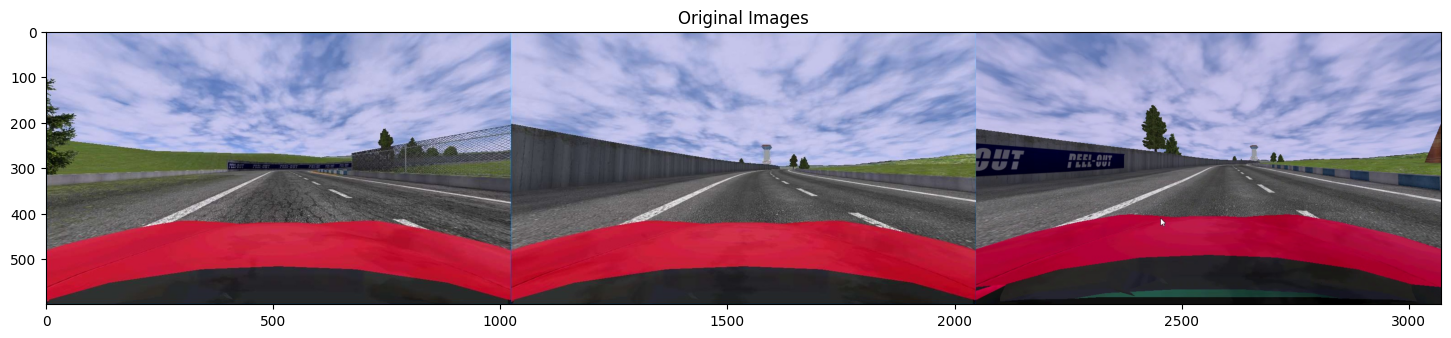

<Figure size 1800x600 with 0 Axes>

In [17]:
original_images = []
file_paths = ["road-images/sd1.jpg","road-images/sd2.jpg","road-images/sd3.jpg"]
for file_path in file_paths:
    original_images.append(cv2.imread(file_path))

print_ = mathplot_display_concatenated("Original Images", original_images, "h")

Perspective Warping
===
Perspective Correction for "Birds Eye View"


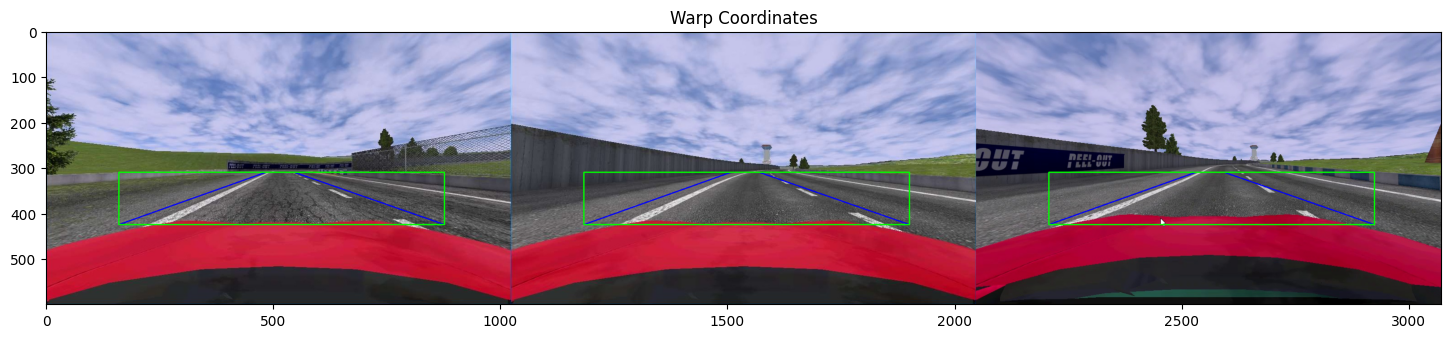

<Figure size 1800x600 with 0 Axes>

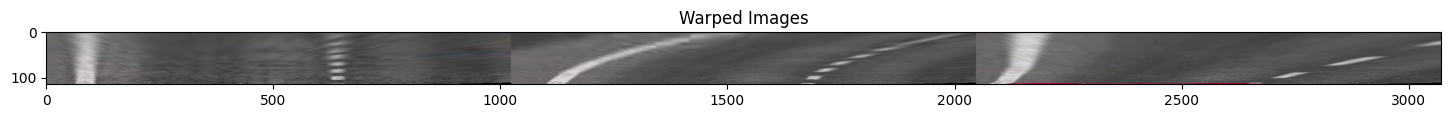

<Figure size 1800x600 with 0 Axes>

In [18]:
original_images_copy = [original_image.copy() for original_image in original_images]
warp_coord = [(160, 425), (484, 310), (546, 310), (877, 425)]
destination_size = (1024,600)

warped_images = [original_image for original_image in original_images]

###########################################
# compute perspective
###########################################
def compute_perspective(warp_coord):
    global perspective_correction, perspective_correction_inv

    max_x = max([coord[0] for coord in warp_coord])
    min_x = min([coord[0] for coord in warp_coord])
    max_y = max([coord[1] for coord in warp_coord])
    min_y = min([coord[1] for coord in warp_coord])
    
    width = max_x - min_x
    height = max_y - min_y

    src = np.float32(warp_coord)
    dst = np.float32([(0, height), (0, 0), (width, 0), (width, height)])

    perspective_correction = cv2.getPerspectiveTransform(src, dst)
    perspective_correction_inv = cv2.getPerspectiveTransform(dst, src)

def warp_images(images, warp_coord, destination_size):
    draw_images = [image.copy() for image in images]

    max_x = max([coord[0] for coord in warp_coord])
    min_x = min([coord[0] for coord in warp_coord])
    max_y = max([coord[1] for coord in warp_coord])
    min_y = min([coord[1] for coord in warp_coord])
    
    ###########################################
    # draw warp coordinates on image and show
    ###########################################
    for i in range(len(draw_images)):
        # draw line for warp coordinates
        cv2.line(draw_images[i], warp_coord[0], warp_coord[1], (255,0,0), 2)
        cv2.line(draw_images[i], warp_coord[1], warp_coord[2], (255,0,0), 2)
        cv2.line(draw_images[i], warp_coord[2], warp_coord[3], (255,0,0), 2)
        cv2.line(draw_images[i], warp_coord[3], warp_coord[0], (255,0,0), 2)

        # draw rectangle for destination size
        cv2.rectangle(draw_images[i], (min_x, min_y), (max_x, max_y), (0,255,0), 2)
  
    mathplot_display_concatenated("Warp Coordinates", draw_images, "h")

    for i in range(len(images)):
        warped_images[i] = cv2.warpPerspective(images[i], perspective_correction, (destination_size[0], max_y-min_y), flags=cv2.INTER_LINEAR)
    
    return warped_images

compute_perspective(warp_coord)
warped_images = warp_images(original_images_copy, warp_coord, destination_size)
plt.figure()
mathplot_display_concatenated("Warped Images", warped_images, "h")



Color Threshold
===
Single out Color Spaces suitable for information extraction
- Green
- Lightness from HLS

[array([[ 0., 10., 10., ...,  0.,  6.,  0.],
       [ 0.,  3.,  3., ...,  0.,  7.,  0.],
       [ 0.,  0.,  0., ...,  3., 10.,  0.],
       ...,
       [ 0., 61.,  3., ...,  3., 15.,  0.],
       [ 0., 45., 20., ...,  0.,  0.,  0.],
       [ 0.,  2., 12., ...,  0.,  0.,  0.]]), array([[  0.,   0.,   0., ...,  48.,  48.,   0.],
       [  0.,   0.,   0., ...,  45.,  45.,   0.],
       [  0.,   0.,   0., ...,  35.,  35.,   0.],
       ...,
       [  0.,  10., 162., ...,   6.,   9.,   0.],
       [  0.,  60.,  72., ...,   0.,   0.,   0.],
       [  0., 138.,  38., ...,   0.,   0.,   0.]]), array([[  0.,   0.,   0., ...,  10.,   6.,   0.],
       [  0.,   0.,   0., ...,   3.,   7.,   0.],
       [  0.,   0.,   0., ...,   3.,  10.,   0.],
       ...,
       [  0., 108.,  82., ...,   0.,   9.,   0.],
       [  0.,  89., 117., ...,   0.,   0.,   0.],
       [  0.,  18.,  22., ...,   0.,   0.,   0.]])]


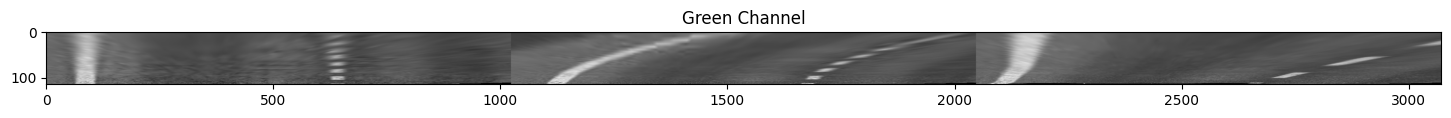

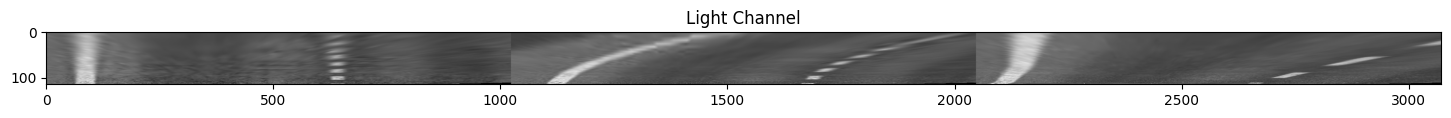

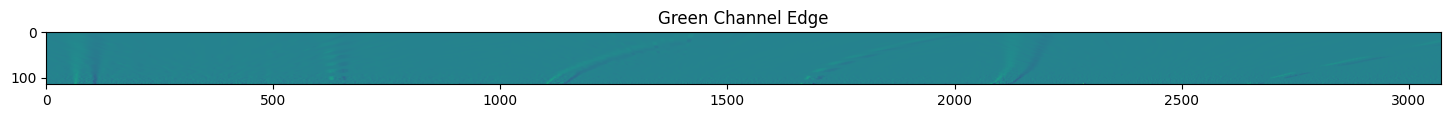

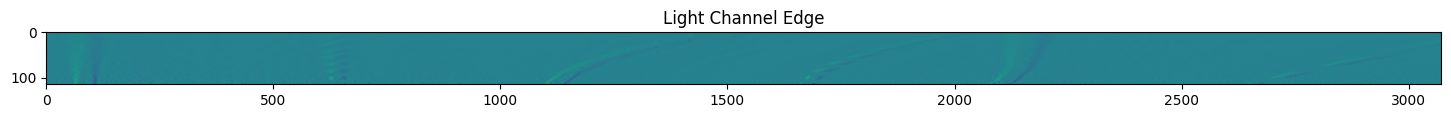

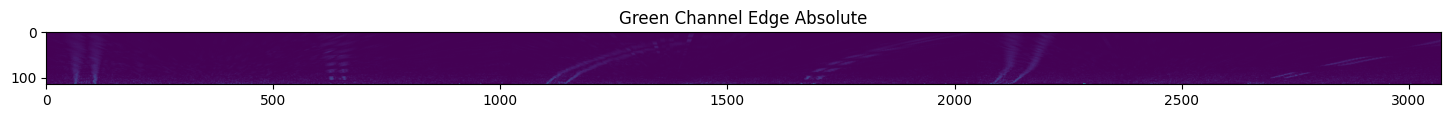

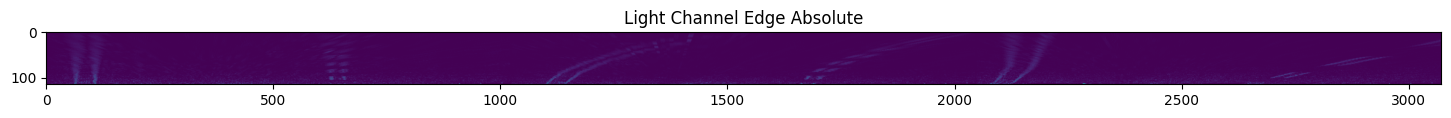

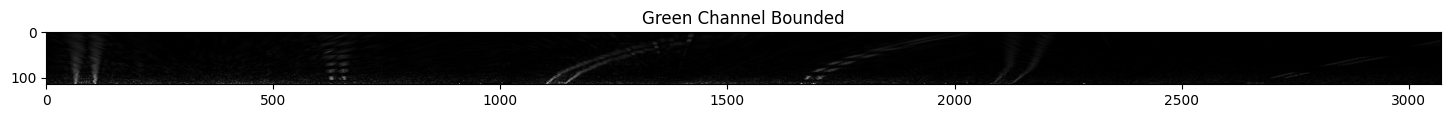

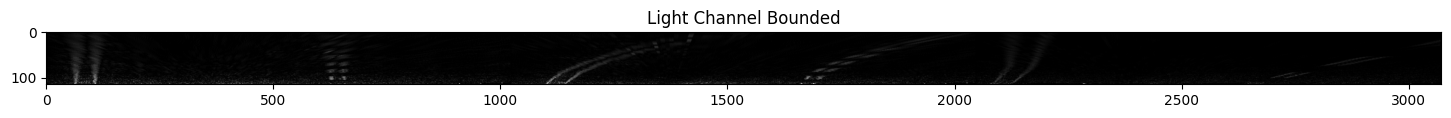

<Figure size 1800x600 with 0 Axes>

In [30]:
hls_images = [cv2.cvtColor(image, cv2.COLOR_BGR2HLS) for image in warped_images]
green_channel = [image[:,:,1] for image in warped_images] # 1: green channel
light_channel = [image[:,:,1] for image in hls_images] # 1: lightness channel (FROM HLS)

mathplot_display_concatenated("Green Channel", green_channel, "h")
mathplot_display_concatenated("Light Channel", light_channel, "h")

green_channel_edge_X = [cv2.Scharr(image, cv2.CV_64F, 1, 0) for image in green_channel]
light_channel_edge_X = [cv2.Scharr(image, cv2.CV_64F, 1, 0) for image in light_channel]

mathplot_display_concatenated("Green Channel Edge", green_channel_edge_X, "h")
mathplot_display_concatenated("Light Channel Edge", light_channel_edge_X, "h")

green_channel_edge_X = [np.absolute(image) for image in green_channel_edge_X]
light_channel_edge_X = [np.absolute(image) for image in light_channel_edge_X]

mathplot_display_concatenated("Green Channel Edge Absolute", green_channel_edge_X, "h")
mathplot_display_concatenated("Light Channel Edge Absolute", light_channel_edge_X, "h")

green_channel_edge_X = [np.uint8(255*image/np.max(image)) for image in green_channel_edge_X]
light_channel_edge_X = [np.uint8(255*image/np.max(image)) for image in light_channel_edge_X]

mathplot_display_concatenated("Green Channel Bounded", green_channel_edge_X, "h")
mathplot_display_concatenated("Light Channel Bounded", light_channel_edge_X, "h")
